# Create Vanilla CNN to Classify Gabor Tilts
### [Vanilla CNN Tensorflow tutorial](https://www.tensorflow.org/tutorials/images/cnn).
--- 
## Import libraries

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import os

### Load and prepare the data
The dataset is comprised of 18,000 total Gabors in two classes representing tilts from 45 degrees in the clockwise direction and tilts in the counterclockwise direction. The Gabors were generated in MATLAB using gen_gabor-range.m according to a range of 18 unique tilt/contrast combinations. 
- `tilts = [.1, .2, .4, .8, 1.6, 3.2]; # measured in degrees`
- `contrasts = [.3, .45, 1];  # measured in percent`  

500 Gabors were generated for each of the 18 groups for each of the 2 classes (500 x 18 x 2 = 18,000 total images). The dataset is divided into 11,988 training images, 4,788 validation images, and 1,224 testing images. The batch size was set at 32 and image size at 160 x 160.

In [4]:
def load_data():
    curr_dir = os.getcwd() 
    train_dir = os.path.join(curr_dir, 'images/train_range')
    validation_dir = os.path.join(curr_dir, 'images/validation_range')
    test_dir = os.path.join(curr_dir, 'images/test_range')
    BATCH_SIZE = 32 
    IMG_SIZE = (160, 160)
    train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE) 
    validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE) 
    test_dataset = image_dataset_from_directory(test_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE) 
    class_names = train_dataset.class_names #assign clockwise (clock) & counterclockwise (cclock) classes
    # Normalize pixel values to be between 0 and 1
    train_dataset, test_images = train_images / 255.0, test_images / 255.0
    return BATCH_SIZE,IMG_SIZE,train_dataset,validation_dataset,test_dataset,class_names

BATCH_SIZE, IMG_SIZE, train_dataset, validation_dataset, test_dataset, class_names = load_data()

Found 11988 files belonging to 2 classes.
Found 4788 files belonging to 2 classes.
Found 1224 files belonging to 2 classes.


In [19]:
#dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
#def normalize_images(ds):
  #return ds.filter(lambda x,y: x/255.0)
#norm_test_dataset = test_dataset.apply(normalize_images)
norm_test_dataset = test_dataset.map(lambda images,labels: images/255.0)
#list(dataset.as_numpy_iterator())


### Verify the data
To verify that the dataset looks correct, let's plot the first 9 images from the training set and display the class name above each image:

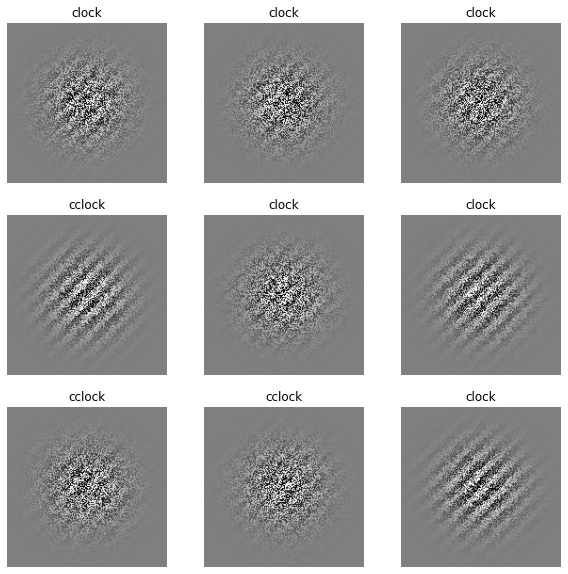

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1): #load first iteration batch from training dataset
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1) #setup axis on a 3x3 grid
    plt.imshow(images[i].numpy().astype("uint8"),cmap='gray') #plot each image
    plt.title(class_names[labels[i]]) #output associated label for chosen image
    plt.axis("off")

### Standardize the data
The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general we should seek to make our input values small. We will standardize values to be in the `[0, 1]` range by using the `tf.keras.layers.experimental.preprocessing.Rescaling` layer.

In [22]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

# set this up in google colab and continue following it to normalize our images: https://www.tensorflow.org/tutorials/load_data/images

### Setup buffered prefetching
We can configure the dataset for performance using buffered prefetching to load images from disk without having I/O become blocking

In [6]:
def prefetch(train_dataset, validation_dataset, test_dataset):
    AUTOTUNE = tf.data.AUTOTUNE #prompts the tf.data runtime to tune the value dynamically at runtime
    train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE) #will prefetch an optimal number of batches
    validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE) #will prefetch an optimal number of batches
    test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE) #will prefetch an optimal number of batches
    return train_dataset,validation_dataset,test_dataset,AUTOTUNE

train_dataset, validation_dataset, test_dataset, AUTOTUNE = prefetch(train_dataset, validation_dataset, test_dataset)

### Create the convolutional base

The 6 lines of code below define the convolutional base using a common pattern: a stack of [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. color_channels refers to (R,G,B). We will configure the CNN to process inputs of shape (160, 160, 3), which is the format of our Gabors. We can do this by passing the argument `input_shape` to the first layer.

In [9]:
model = models.Sequential()
model.add(layers.Conv2D(160, (3, 3), activation='relu', input_shape=(160, 160, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(320, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(320, (3, 3), activation='relu'))

Let's display the architecture of the model so far:

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 158, 158, 160)     4480      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 79, 79, 160)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 77, 77, 320)       461120    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 320)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 36, 320)       921920    
Total params: 1,387,520
Trainable params: 1,387,520
Non-trainable params: 0
_________________________________________________________________


Above, you can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as we go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 160 or 320). Typically, as the width and height shrink, we can afford (computationally) to add more output channels in each Conv2D layer.

### Add dense layers on top
To complete the model, we will feed the last output tensor from the convolutional base (of shape (36, 36, 320)) into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, we will flatten (or unroll) the 3D output to 1D,  then add one or more Dense layers on top. Our dataset has 2 output classes, so we use a final Dense layer with 1 output.